In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import *
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FasterRCNN, FastRCNNPredictor
from torchvision.datasets import VOCDetection
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("CUDA unavailable; switching to CPU")
    device = torch.device("cpu")

In [3]:
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights = weights)
model = model.to(device)

In [4]:
transform = transforms.Compose([ToTensor()])
dataset = VOCDetection("~/datasets/VOCDetection", transform = transform)

In [5]:
all_objs = []
for ds in dataset:
    obj_annots = ds[1]["annotation"]["object"]
    for obj in obj_annots:
        all_objs.append(obj["name"])

unique_class_labels = set(all_objs)
print("Number of unique objects in dataset: ", len(unique_class_labels))
print("Unique labels in dataset: \n", unique_class_labels)

Number of unique objects in dataset:  20
Unique labels in dataset: 
 {'dog', 'bird', 'person', 'aeroplane', 'pottedplant', 'bus', 'cat', 'chair', 'bottle', 'tvmonitor', 'motorbike', 'train', 'sofa', 'diningtable', 'bicycle', 'car', 'boat', 'cow', 'horse', 'sheep'}


In [6]:
name_to_label = {'pottedplant': 1, 'person': 2, 'motorbike': 3, 'train': 4,
               'dog': 5, 'diningtable': 6, 'horse': 7, 'bus': 8,
               'aeroplane': 9, 'sofa': 10, 'sheep': 11, 'tvmonitor': 12,
               'bird': 13, 'bottle': 14, 'chair': 15, 'cat': 16,
               'bicycle': 17, 'cow': 18, 'boat': 19, 'car': 20, 'bg': 0}
label_to_name = {value:key for key, value in name_to_label.items()}

In [7]:
def is_box_valid(box):
    if (box[0] < box[2]) and (box[1] < box[3]):
        return True
    else:
        return False

In [8]:
def process_voc(dataset):
    images, targets = [], []
    for sample in dataset:
        # get the bounding boxes
        sample_boxes = []
        sample_labels = []
        for obj in sample[1]["annotation"]["object"]:
            # get the bounding boxes
            box = obj["bndbox"]
            coords = torch.tensor([int(coord) for coord in box.values()])
            if not is_box_valid(coords):
                continue
            sample_boxes.append(coords)
            
            # get the corresponding labels
            name = obj["name"]
            label = name_to_label[name]
            sample_labels.append(label)

        if sample_boxes == []:
            continue
        sample_dict = {"boxes": torch.vstack(sample_boxes), 
                       "labels": torch.tensor(sample_labels)}

        # save the image
        image = sample[0]
        images.append(image)
        # save the targets
        targets.append(sample_dict)
    return images, targets

In [9]:
images, targets = process_voc(dataset)
def collate_fn(batch):
    return tuple(zip(*batch))
loader = DataLoader(list(zip(images, targets)),
                     batch_size = 16, 
                     collate_fn = collate_fn)

In [10]:
idx = 4
print(images[idx].shape)
print(targets[idx]["boxes"])
print(targets[idx]["labels"])

torch.Size([3, 375, 500])
tensor([[158, 199, 231, 240],
        [ 47, 202,  94, 238]])
tensor([20, 20])


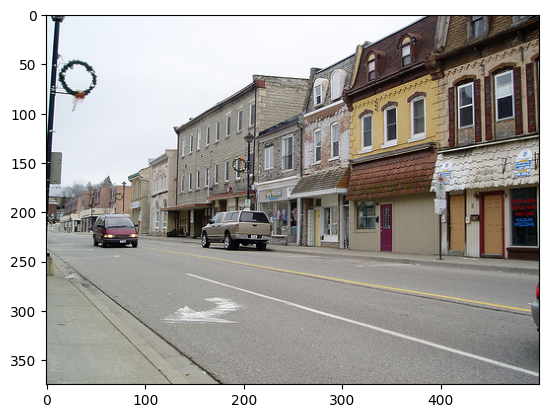

In [11]:
plt.imshow(images[idx].permute(1, 2, 0))

In [12]:
batch = next(iter(loader))
imgs, lbls = batch
images = tuple(img.to(device) for img in imgs)
labels = tuple({k:v.to(device) for k, v in d.items()} for d in lbls)

In [13]:
with torch.no_grad():
    preds = model(images, labels)
preds

{'loss_classifier': tensor(0.9979, device='cuda:0'),
 'loss_box_reg': tensor(0.1548, device='cuda:0'),
 'loss_objectness': tensor(0.0110, device='cuda:0'),
 'loss_rpn_box_reg': tensor(0.0123, device='cuda:0')}

In [14]:
images = tuple(img.to("cpu") for img in images)
labels = tuple({k:v.to("cpu") for k, v in d.items()} for d in labels)
preds = {k:v.to("cpu").detach() for k, v in preds.items()}
preds

{'loss_classifier': tensor(0.9979),
 'loss_box_reg': tensor(0.1548),
 'loss_objectness': tensor(0.0110),
 'loss_rpn_box_reg': tensor(0.0123)}

# Set up the model to predict with the new number of classes

In [15]:
num_classes = len(unique_class_labels) + 1 # Number of actual classes + 1 background class
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [16]:
sample = next(iter(loader))
image = sample[0][2]

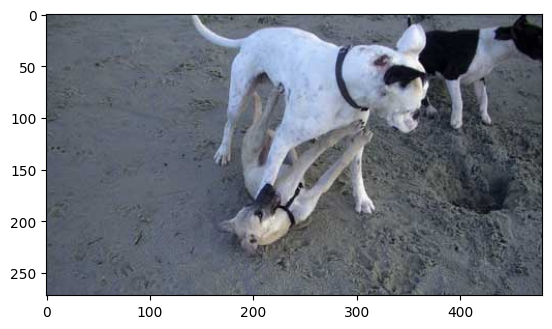

In [17]:
plt.imshow(image.permute(1, 2, 0))

In [18]:
model.eval().to(device)
image = image.unsqueeze(dim = 0).to(device)
model(image)
model.to("cpu")
image.to("cpu")

tensor([[[[0.3020, 0.3059, 0.3098,  ..., 0.3098, 0.2980, 0.2902],
          [0.2980, 0.3059, 0.3098,  ..., 0.2980, 0.3020, 0.3098],
          [0.2941, 0.3020, 0.3059,  ..., 0.2706, 0.2863, 0.3020],
          ...,
          [0.3176, 0.3216, 0.3216,  ..., 0.3216, 0.3176, 0.3098],
          [0.3059, 0.3098, 0.3137,  ..., 0.3098, 0.3216, 0.3569],
          [0.2980, 0.3020, 0.3098,  ..., 0.3020, 0.3333, 0.4000]],

         [[0.3294, 0.3333, 0.3373,  ..., 0.3412, 0.3294, 0.3216],
          [0.3255, 0.3333, 0.3373,  ..., 0.3294, 0.3333, 0.3412],
          [0.3216, 0.3294, 0.3333,  ..., 0.2980, 0.3137, 0.3294],
          ...,
          [0.3412, 0.3451, 0.3451,  ..., 0.3490, 0.3451, 0.3373],
          [0.3294, 0.3333, 0.3373,  ..., 0.3373, 0.3490, 0.3843],
          [0.3216, 0.3255, 0.3333,  ..., 0.3294, 0.3608, 0.4275]],

         [[0.3529, 0.3569, 0.3608,  ..., 0.3529, 0.3412, 0.3333],
          [0.3490, 0.3569, 0.3608,  ..., 0.3412, 0.3451, 0.3529],
          [0.3451, 0.3529, 0.3569,  ..., 0

# Fine-tune model

In [19]:
for param in model.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

In [20]:
train = False
if train:
    epochs = 20
    opt = torch.optim.Adam(model.roi_heads.box_predictor.parameters(), lr = 1e-4)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.9, patience = 5)
    model.train().to(device)
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        running_loss = 0.
        batches = 0
        for batch in loader:
            imgs, lbls = batch
            images = tuple(img.to(device) for img in imgs)
            labels = tuple({k:v.to(device) for k, v in d.items()} for d in lbls)

            opt.zero_grad()
            loss_vals = model(images, labels)
            loss = sum(loss_val for loss_val in loss_vals.values())
            loss.backward()
            opt.step()        

            running_loss += loss
            batches += 1
        
        average_loss = running_loss/batches
        lr_scheduler.step(average_loss)
        print(f"Average Loss per Batch: {average_loss}")
    torch.save(model, "../model_weights/object_detector.pt")
else:
    model = torch.load("../model_weights/object_detector.pth", weights_only = False)

In [21]:
image = dataset[torch.randint(1, len(dataset), (1,))][0].unsqueeze(dim = 0).to(device)
model.eval().to(device)
out = model(image)[0]
boxes = out["boxes"]
labels = [int(label.cpu()) for label in out["labels"]]
labels = [label_to_name[label] for label in labels]
labels

['horse', 'horse', 'horse', 'horse', 'horse']

In [22]:
boxed = draw_bounding_boxes(image[0], boxes, labels)

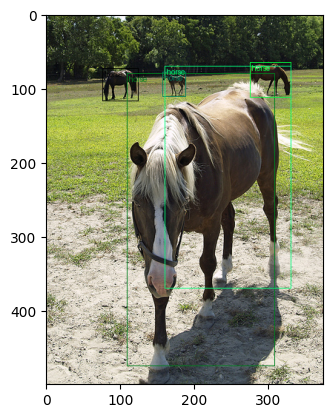

In [23]:
plt.imshow(boxed.permute(1, 2, 0))